In [1]:
pip install yahoofinancials

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import statistics as st

In [3]:
# Print example for Tesla

tsla_df = yf.download('TSLA', 
                      start='2019-01-01', 
                      end='2019-12-31', 
                      progress=False)
tsla_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,20.406668,21.008667,19.920000,20.674667,20.674667,174879000
2019-01-03,20.466667,20.626667,19.825333,20.024000,20.024000,104478000
2019-01-04,20.400000,21.200001,20.181999,21.179333,21.179333,110911500
2019-01-07,21.448000,22.449333,21.183332,22.330667,22.330667,113268000
2019-01-08,22.797333,22.934000,21.801332,22.356667,22.356667,105127500


In [4]:
def get_data(stocks, start, end):
    stockData = yf.download(stocks, start, end, progress = False)
    stockData = stockData['Close']
    returns = stockData.pct_change().apply(lambda x: np.log(1+ x))
    var = returns.var()
    volatility = np.sqrt(var * 250)
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


In [5]:
stockList = ['BHP','CBA','TLS','NAB','WBC','STO']

stock = [stock + '.AX' for stock in stockList]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 300)

meanReturns, covMatrix = get_data(stock, startDate, endDate)

/Users/felixambrose/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
stock_index = meanReturns.index

In [7]:
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

In [8]:
# Monte Carlo Method

sims = 1000
T = 100

meanM = np.full(shape = (T, len(weights)), fill_value = (meanReturns))
meanM = meanM.T

portfolioSims = np.full(shape = (T, sims), fill_value = 0.0)

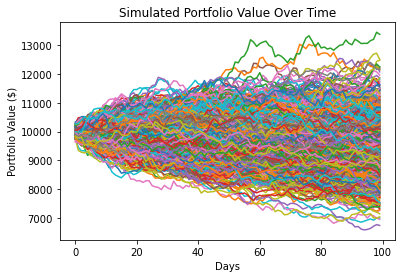

In [9]:
initialPortfolio = 10000


for m in range(0, sims):
    Z = np.random.normal(size = (T, len(weights)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L,Z)
    portfolioSims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+ 1)*initialPortfolio
    
plt.plot(portfolioSims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Simulated Portfolio Value Over Time')
plt.show()    

## Portfolio Weight Optimisation

In [10]:
# Monte Carlo Method

sims = 5000
T = 100

meanM = np.full(shape = (T, len(stockList)), fill_value = (meanReturns))
meanM = meanM.T

portfolioSims = np.full(shape = (T, sims), fill_value = 0.0)

## Random Sampling Loop

## First Loop

- Iterates through the number of simulations, each time selecting random weights for the stocks within the portfolio

## Inner Loop

- For each random weight sample, we iterate 50 times and take the average return and average standard deviation

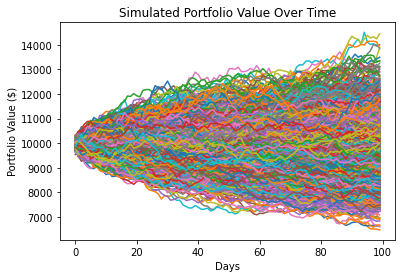

In [11]:
initialPortfolio = 10000

# Prepping arrays
daily_returns = []
# Mean returns
returns = []
# Standard Deviation
volatility = []
# Stock weights
stock_weight = []
sharpe = []
simulation_df = []
#cum_ret = []

for m in range(0, sims):
    weights = np.random.random(len(meanReturns))
    weights /= np.sum(weights)
    stock_weight.append(list(weights))
    temp_vol = []
    temp_ret = []
    #temp_cum_ret = np.full(shape = (T, 50), fill_value = 0.0)
    for i in range(0,50):
        Z = np.random.normal(size = (T, len(weights)))
        L = np.linalg.cholesky(covMatrix)
        dailyReturns = meanM + np.inner(L,Z)
        #daily_returns.append(dailyReturns)
        temp_ret.append(dailyReturns.mean())
        #volatility.append(st.stdev(dailyReturns))
        var = covMatrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() #Portolio Variance
        sd = np.sqrt(var) # Portfolio SD
        vol = sd*np.sqrt(250) # Annual volatility
        temp_vol.append(vol)
        portfolioSims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+ 1)*initialPortfolio
        #temp_cum_ret[:,i] = np.cumprod(np.inner(weights, dailyReturns.T)+ 1)*initialPortfolio
    #cum_ret.append(temp_cum_ret[-1].mean())
    returns.append(sum(temp_ret)/len(temp_ret))
    volatility.append(sum(temp_vol)/len(temp_vol))
    
    
plt.plot(portfolioSims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('Simulated Portfolio Value Over Time')
plt.show()    

In [12]:
df = pd.DataFrame({'Returns': returns,'Volatility': volatility,'Weights': stock_weight})

In [13]:
# We can now calculate the Sharpe ratio (risk adjusted return) Since the rate of interest is low, we will assume that the risk free rate is 0. 

df['Sharpe'] = df['Returns']/df['Volatility']

In [14]:
# We can now select the portolios with the top 5 average sharpe ratios

top_5 = df.sort_values('Sharpe', ascending = False).head()

top_5

,Returns,Volatility,Weights,Sharpe
3530,0.000131,0.152942,"[0.17157304026638276, 0.1347858453232266, 0.22...",0.000859
743,0.000081,0.147603,"[0.028706789676694475, 0.08674786000313717, 0....",0.000549
732,0.000069,0.156814,"[0.21904273924202, 0.1812397535763686, 0.25268...",0.000442
2664,0.000072,0.174971,"[0.18588857653396607, 0.38697471475600315, 0.1...",0.000414
1308,0.000063,0.155517,"[0.09858379862897913, 0.3071357107062639, 0.10...",0.000403


<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

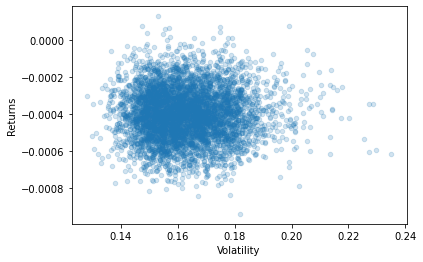

In [22]:
# Plotting the Efficient Frontier

df.plot.scatter('Volatility','Returns', alpha = 0.2)

In [16]:
optimised = top_5.head(1)

for index, row in optimised.iterrows():
    weights = row[2]
    for i in range(0,6):
        print('The weight for stock {} is {}'.format(stock_index[i], weights[i]))

The weight for stock BHP.AX is 0.17157304026638276
The weight for stock CBA.AX is 0.1347858453232266
The weight for stock NAB.AX is 0.22346852361486333
The weight for stock STO.AX is 0.19921541955264088
The weight for stock TLS.AX is 0.2447884238447114
The weight for stock WBC.AX is 0.02616874739817515


In [18]:
meanReturns

BHP.AX   -0.000007
CBA.AX   -0.000482
NAB.AX   -0.000618
STO.AX   -0.000965
TLS.AX    0.000251
WBC.AX   -0.000591
dtype: float64